In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# README

## Usage

`output_qd.csv` and `output_rtt.csv` (as generated by the client program) should
be placed inside `DATA_DIR` as defined below - this directory can be modified
(in the case that you have several outputs backed up in different directories)

## Data layout

The data is stored as `.csv`, with each file representing a vector of 
histograms - that is, one histogram for every `(throughput, srv)` pair. The rows
are 

- `nanos`: the first nanosecond value in a histogram bucket
- `count`: the number of counted data points in a bucket
- `throughput`: the throughput in Rps of a data point
- `srv`: one tenth of the configured service time for the data point

In [42]:
DATA_DIR = '.'

In [43]:
df_qd  = pd.read_csv(DATA_DIR+'/output_qd.csv').sort_values(by="nanos")
df_rtt = pd.read_csv(DATA_DIR+'/output_rtt.csv').sort_values(by="nanos")

In [44]:
# queuing delay dataframe
df_qd

,nanos,count,throughput,srv_time
545,0,626,40000,1
1955,0,445,320000,10
1360,0,1067,160000,1
819,0,1110,80000,1
389,0,402,20000,1
...,...,...,...,...
1481,92203000,1,160000,1
1395,92251000,1,160000,1
1480,92396000,1,160000,1
1687,92640000,1,160000,1


In [45]:
# round trip time dataframe
df_rtt

,nanos,count,throughput,srv_time
849,2000,3,20000,1
19815,2000,23,320000,1
8044,2000,8,80000,1
13482,2000,2,160000,1
9214,2000,1,80000,10
...,...,...,...,...
13283,95434000,1,160000,1
13282,95516000,1,160000,1
13279,95766000,1,160000,1
13278,96132000,1,160000,1


In [46]:
def find_percentile_index(df: pd.DataFrame, percentile: float) -> int:
    """
    finds the row index of the 99th percentile `nanos` value of a dataframe
    """
    total_packets = df[f'count'].sum()
    target_count = total_packets * (percentile / 100)
    return np.argmax(df[f'cum_count'] >= target_count)

In [47]:
grouped_qds = df_qd.groupby(['throughput', 'srv_time'])
grouped_rtts = df_rtt.groupby(['throughput', 'srv_time'])

p99_qds = {}
for (throughput, service_time), sub_df in grouped_qds:
    sub_df['cum_count'] = sub_df['count'].cumsum()
    idx = find_percentile_index(sub_df, 99)
    p99_qd = sub_df.iloc[idx]["nanos"] / 1000.0

    p99_qds[service_time] = p99_qds.get(service_time, {})
    p99_qds[service_time][throughput] = p99_qd

p99_rtts = {}
for (throughput, rtt), sub_df in grouped_rtts:
    sub_df['cum_count'] = sub_df['count'].cumsum()
    idx = find_percentile_index(sub_df, 99)
    p99_rtt = sub_df.iloc[idx]["nanos"] / 1000.0

    p99_rtts[rtt] = p99_rtts.get(rtt, {})
    p99_rtts[rtt][throughput] = p99_rtt
print(p99_rtts)

{1: {10000: 8893.0, 20000: 23531.0, 40000: 7176.0, 80000: 9433.0, 160000: 12071.0, 320000: 14894.0}, 10: {10000: 8815.0, 20000: 22605.0, 40000: 6944.0, 80000: 9575.0, 160000: 11139.0, 320000: 14497.0}}


In [48]:
srv_times = df_qd['srv_time'].unique()

# Generate 99th percentile queuing delay vs. throughput plots for all distinct service time values

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


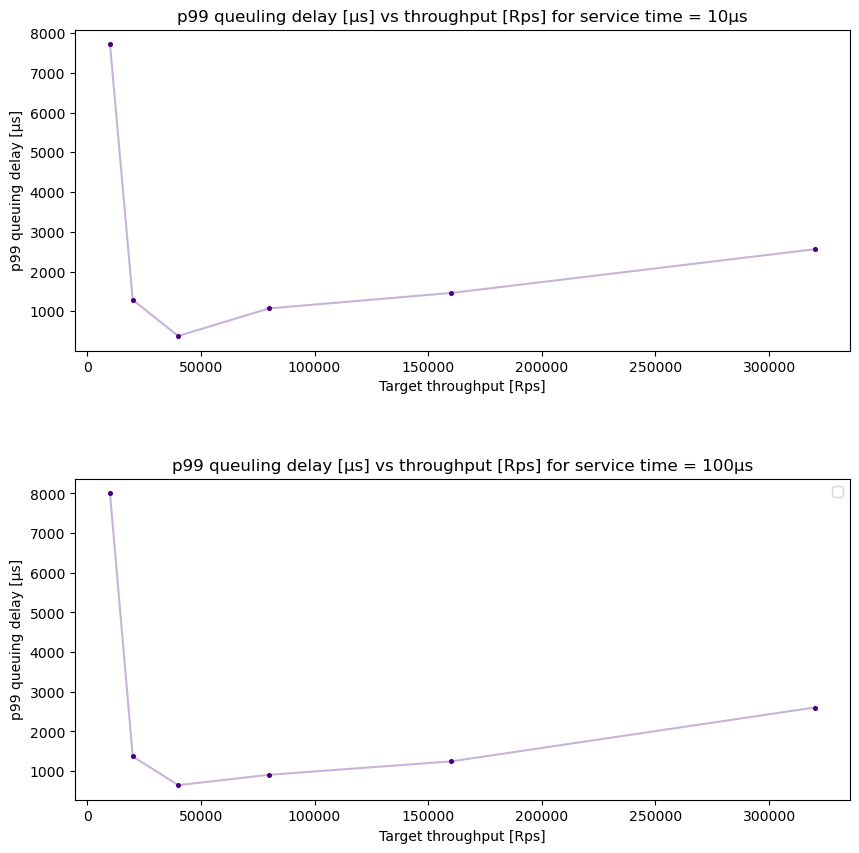

In [49]:
fig, axes = plt.subplots(len(srv_times), 1, figsize=(10, 5*len(srv_times)))

plt.title(f'p99 queuling delay [μs] vs throughput [Rps]')
plt.legend()
plt.subplots_adjust(hspace=0.4)

for i, srv in enumerate(srv_times):
    ax = axes[i] if len(srv_times) > 1 else axes

    plot_data = p99_qds[srv]

    ax.plot(plot_data.keys(), plot_data.values(), color='indigo', alpha=0.3)
    ax.scatter(plot_data.keys(), plot_data.values(), color='indigo', s=7)
    ax.set_title(f'p99 queuling delay [μs] vs throughput [Rps] for service time = {srv*10}μs')
    ax.set_ylabel("p99 queuing delay [μs]")
    ax.set_xlabel("Target throughput [Rps]")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


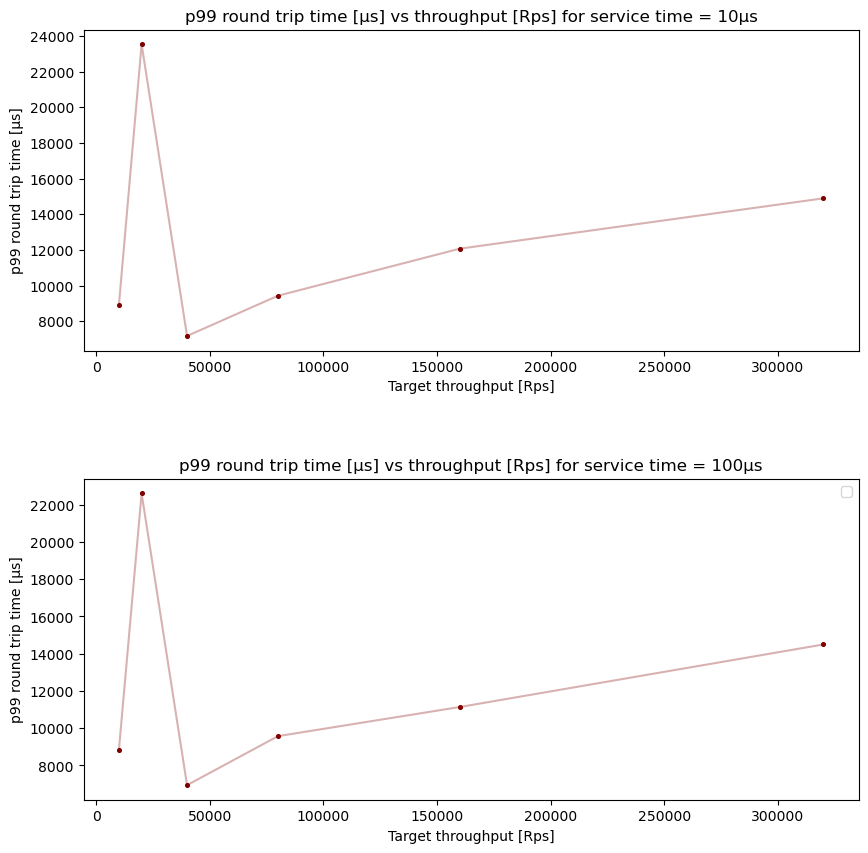

In [50]:
fig, axes = plt.subplots(len(srv_times), 1, figsize=(10, 5*len(srv_times)))

plt.title(f'p99 round trip times delay [μs] vs throughput [Rps]')
plt.legend()
plt.subplots_adjust(hspace=0.4)

for i, srv in enumerate(srv_times):
    ax = axes[i] if len(srv_times) > 1 else axes

    plot_data = p99_rtts[srv]

    ax.plot(plot_data.keys(), plot_data.values(), color='maroon', alpha=0.3)
    ax.scatter(plot_data.keys(), plot_data.values(), color='maroon', s=7)
    ax.set_title(f'p99 round trip time [μs] vs throughput [Rps] for service time = {srv*10}μs')
    ax.set_ylabel("p99 round trip time [μs]")
    ax.set_xlabel("Target throughput [Rps]")